In [26]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import lightgbm as lgb

from lightgbm import LGBMClassifier

from sklearn.datasets import make_classification

from sklearn.model_selection import GridSearchCV,train_test_split

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [27]:
# Generate synthetic dataset

X,y = make_classification(n_samples=1000,
                          n_features=20,
                          n_informative=15,
                          n_redundant=5,
                          random_state=42
                          )

In [28]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [29]:
# Convert data into LightGBM dataset format

train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test, reference=train_data )

In [30]:
# Hyper parameters for the lightgbm model

params = {

    'objective' : 'binary', # Binary Classification
    'metric': 'accuracy',   # Use accuracy as the evaluation metric
    'boosting_type': 'gbdt', # Gradient Boosting Decision Tree
    'learning_rate': 0.05,   # Step size shrinkage 
    'num_leaves': 31,        # Maximum number of leaves in one tree
    'max_depth': -1,         # No depth limit (fully grown trees)
    'min_data_in_leaf': 20,  # Minimum samples per leaf
    'feature_fraction': 0.8, # Use 80% of features per iteration
    'bagging_fraction': 0.8, # Use 80% of data per iteration
    'bagging_freq': 5,       # Perform Bagging every 5 iterations
    'verbose': -1            # Suppress warnings

}

In [31]:
# Train the model

model = lgb.train(
    params,
    train_data, 
    valid_sets=[(test_data)],
    num_boost_round=500
    # callbacks=[
    #     lgb.early_stopping(stopping_rounds=50),  # ✅ Fix for early stopping
    #     lgb.log_evaluation(period=50)  # ✅ Fix for verbose output (replaces verbose_eval)
    # ]
    )

Model Evaluation

In [32]:
# Make predictions

y_pred = model.predict(X_test)

y_pred = [1 if p > 0.5 else 0 for p in y_pred] # Convert probabilities to binary output

In [33]:
# Compute accuracy

accuracy = accuracy_score(y_test,y_pred)

print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.9350


In [34]:
# Print classification report

print("\n Classification Report \n ", classification_report(y_test,y_pred))


 Classification Report 
                precision    recall  f1-score   support

           0       0.95      0.92      0.94       106
           1       0.92      0.95      0.93        94

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



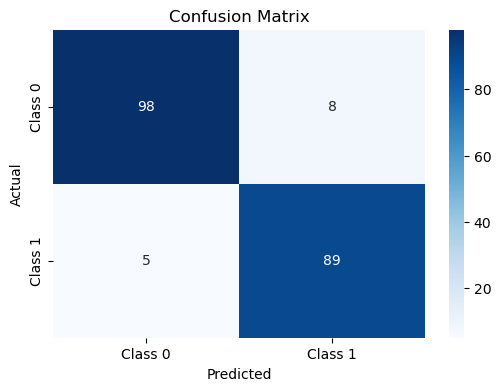

In [35]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(6,4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'],yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.title("Confusion Matrix")

plt.show()

LightGBM provides built-in feature importance visualization.

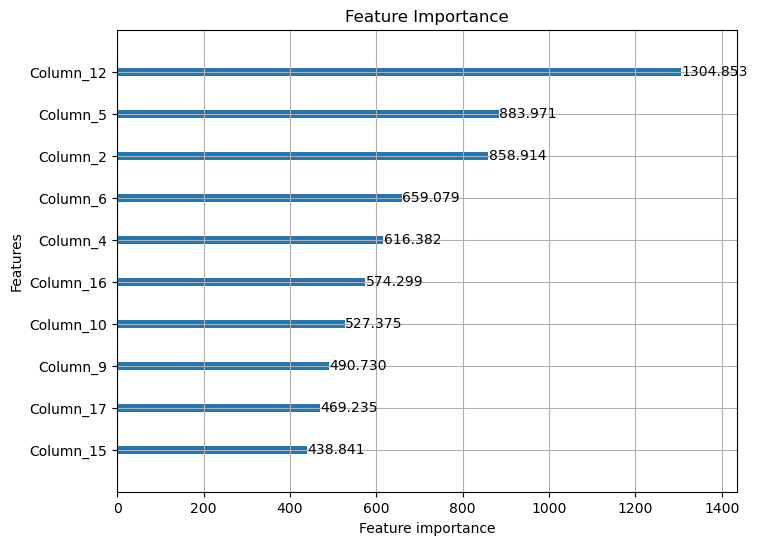

In [36]:
# Feature Importance Plot

lgb.plot_importance(model, max_num_features=10,importance_type='gain', figsize=(8,6))

plt.title('Feature Importance')

plt.show()

Hyperparameter Tuning

In [37]:
# We'll use GridSearchCV to find the best parameters.


# Define parameter grid

param_grid = {

    'num_leaves' : [20,31,40],
    'learning_rate':[0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
}

In [38]:
# Initialize model

lgbm = LGBMClassifier()

In [39]:
# Perform Grid Search

grid = GridSearchCV(
    lgbm,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1)

In [40]:
# Fit Grid Model

grid.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 323, number of negative: 317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4271
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504687 -> initscore=0.018751
[LightGBM] [Info] Start training from score 0.018751
[LightGBM] [Info] Number of positive: 323, number of negative: 317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4272
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504687 -> initscore=0.018751
[LightGBM] [Info] Start training from score 0.018751
[LightGBM] [Info] Number of 

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [20, 31, 40]},
             scoring='accuracy')

In [41]:
# Best Parameters

print(f"Best Parameters : { grid.best_params_}")

Best Parameters : {'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 20}


In [42]:
# Evaluate best model

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)

In [43]:
print(f"Optimized Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")


Optimized Accuracy: 0.9350
